# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import jit,njit,float64,int32
import numba as nb
import pandas as pd
from derivative import dxdt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

from derivative import dxdt

In [165]:
initial_condition = 2
def f(x, alpha_damage_propagation, disease_rate, t=None):
    return alpha_damage_propagation*x + disease_rate

def Runke_Kutta_Method(temporal_evolution:list, disease_rate):
    x = initial_condition                                         #Initial condition     
    frailty_index = np.empty((len(temporal_evolution)))
    for index, t in enumerate(temporal_evolution):
        frailty_index[index] = x
        k1 = h*f(x, alpha_damage_propagation, disease_rate, t=t)
        k2 = h*f(x+0.5*k1, alpha_damage_propagation, disease_rate, t=t +0.5*h)
        x += k2

    gompertz_law = mortality_rate*(frailty_index**(coupling_factor/alpha_damage_propagation))
    return frailty_index, gompertz_law, temporal_evolution

@njit()
def Gillespie(trp0,tmax, N_total, disease_rate):
    """
    Esta funcion se emplea solamente para hacer la evolución de un paso individual en la celula. Evoluciona no un paso temporal, 
    pero si temporalmente la cantidad de veces que pueda evolucionar antes del tmax en una corrida
    """
    t,N, died =trp0 
    while t < tmax and not died :
        s_1 =  alpha_damage_propagation*N + disease_rate*N_total
        s_2 = mortality_rate*((N/N_total)**(coupling_factor/alpha_damage_propagation))
        S_T = s_1 + s_2 

        τ = (-1/S_T)*np.log(np.random.rand())
        x = np.random.rand()
        if x <= (s_1)/S_T:
            N += 1
        else: 
            died = True
            break
        t+=τ
    return np.array([t,N, died]) 
@njit()
def Estado_celula(X0,tiempos, N_total, disease_rate):
    X = np.empty((len(tiempos),len(X0)))
    X[:] = np.nan
    X[0] = X0

    for i in range(1,len(tiempos)):
        X[i] = Gillespie(X[i-1],tiempos[i], N_total, disease_rate)
        if X[i][2]:
            break
    return X

In [151]:
# Lectura datos fenomenologicos
with open('Mx_1x10/AUS.Mx_1x10.txt', 'r') as file:
    # Lee la primera línea (encabezado) y divídela en una lista
    header = file.readline().strip().split()

    # Inicializa listas vacías para almacenar los datos
    years = []
    ages = []
    females = []
    males = []
    totals = []

    row_count = 0
    for line in file:
        row_count += 1
        if row_count == 1:
            continue
        if row_count == 2:
            continue

        data = line.strip().split()
        years.append((data[0]))

        if data[1] == "110+":
            ages.append(110)
        else:
            ages.append(float(data[1]))
        if data[2] == ".":
            females.append(0)
        else:
            females.append(float(data[2]))
        if data[3] == ".":
            males.append(0)
        else:
            males.append(float(data[3]))
        if data[4] == ".":
            totals.append(0)
        else:
            totals.append(float(data[4]))
years = np.array(years)
ages = np.array(ages)
females = np.array(females)
males = np.array(males)
totals = np.array(totals)

In [56]:
years_of_interes = ["1921-1929", "1970-1979", "2010-2019"]

datos_generales = {}
datos_generales["Ages"] = ages[0:100]
for specific_year in years_of_interes:
    posicion_inicial = np.where(years == specific_year)[0][0]
    
    death_rate = totals[posicion_inicial:posicion_inicial+100]
    datos_generales[specific_year] = death_rate

In [148]:
tiempo_vida_inicial = 20
tiempo_vida_maximo = 150            #Para que los resultados obtenidos se encuentren ligados a realidad biologica
pasos_integracion = 150             #Definicion de los pasos de integracion de algoritmo
alpha_damage_propagation = 0.05    #Tasa de propagacion de daño
coupling_factor = 0.09             #Factor de acoplamiento entre frailty index y gompertz
mortality_rate = 4.3*(10**(-5))     #Tasa de mortalidad

In [153]:
disease_rate = 0.02
N_total_nodes = [1000]

In [154]:
h = (tiempo_vida_maximo-tiempo_vida_inicial)/pasos_integracion                                         #Pasos de integracion
temporal_evolution = np.arange(tiempo_vida_inicial,tiempo_vida_maximo,h) 
frailty_index_differential_equation,gompertz_law_differential_equation,temporal_evolution_differential_equation = Runke_Kutta_Method(temporal_evolution, disease_rate)


In [7]:
simulaciones_diferentes_nodos = np.empty((len(N_total_nodes)), dtype = object)

for index, N_node in enumerate(N_total_nodes):
    x0 = np.array([tiempo_vida_inicial, 2, False])
    num_cel = 1*(10**4) #Cantidad de personas que se estan simulando
    celulas = np.array([Estado_celula(x0,np.arange(tiempo_vida_inicial,tiempo_vida_maximo,1.), N_node,disease_rate ) for i in tqdm(range(num_cel))])
    simulaciones_diferentes_nodos[index] = celulas

promedios_simulaciones = np.empty((len(N_total_nodes)), dtype = object)

for index, simulacion_individual in enumerate(simulaciones_diferentes_nodos):

    frailty_index_mean_curve= np.zeros((len(celulas[0])))
    for i in tqdm(np.arange((len(celulas[0])))):
        promedio = np.nanmean(simulaciones_diferentes_nodos[index][:,i,1])
        frailty_index_mean_curve[i] = promedio
    
    promedios_simulaciones[index] = frailty_index_mean_curve

100%|██████████| 130/130 [00:00<00:00, 5131.66it/s]


In [8]:
gompertz_law_stochastic_simulation = mortality_rate*(promedios_simulaciones[0]**(coupling_factor/alpha_damage_propagation))

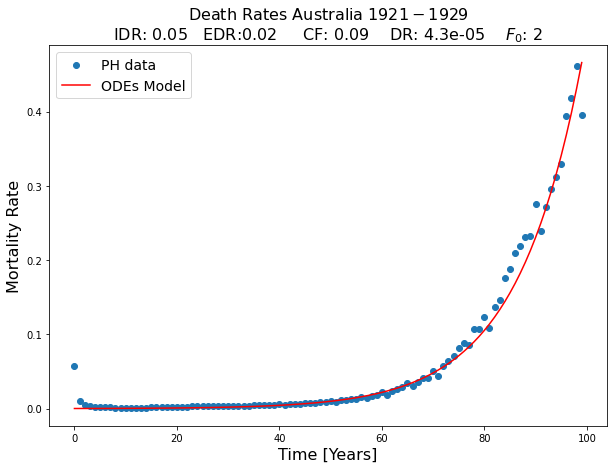

In [172]:

plt.figure(figsize=(10,7))
plt.title(r"Death Rates Australia $1921-1929$" + "\n" + rf"IDR: {alpha_damage_propagation}   EDR:{disease_rate}     CF: {coupling_factor}    DR: {mortality_rate}    $F_0$: {initial_condition}" , fontsize = 16)
plt.xlabel(r"Time [Years]", fontsize = 16)
plt.ylabel(r"Mortality Rate", fontsize = 16)
plt.scatter(datos_generales["Ages"], datos_generales["1921-1929"], label = "PH data")
plt.plot(gompertz_law_differential_equation[0:100], label = "ODEs Model", color = "red")

#plt.plot(gompertz_law_stochastic_simulation[0:100], label = "Stochastic Simulation", color = "green")
plt.legend(fontsize = 14)
plt.savefig("DR_AUS_1921_1929.jpg", dpi = 500)


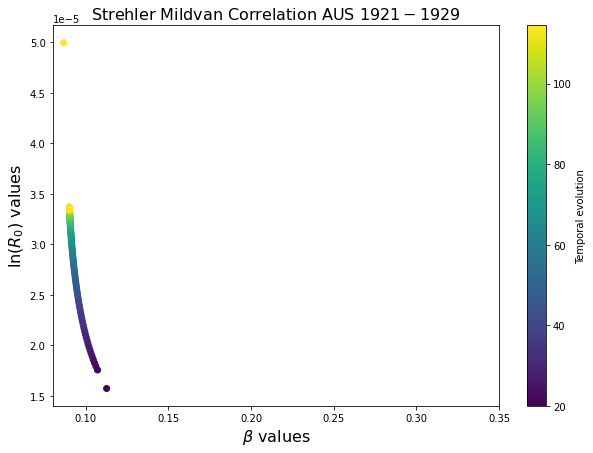

In [173]:
frailty_index = frailty_index_differential_equation[0:110]
gompertz_law = mortality_rate*(frailty_index**(coupling_factor/alpha_damage_propagation))

derivative_process = dxdt(gompertz_law, temporal_evolution_differential_equation[0:110], kind="finite_difference", k=3)
beta_values = derivative_process/gompertz_law
R_values = gompertz_law/np.e**(beta_values*temporal_evolution_differential_equation[0:110])

# Generar datos de ejemplo (reemplaza esto con tus propios datos)
tiempo = temporal_evolution_differential_equation[0:110]
x = beta_values
y = R_values
colores = tiempo

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize = (10,7))

# Crear la curva de color
scatter = ax.scatter(x, y, c=colores, cmap='viridis', marker='o')

# Crear la barra de color
norm = Normalize(vmin=min(colores), vmax=max(colores))
cbar = plt.colorbar(ScalarMappable(norm=norm, cmap='viridis'), ax=ax)
cbar.set_label('Temporal evolution')

# Etiquetas y título
ax.set_xlabel(rf"$\beta$ values", fontsize = 16)
ax.set_ylabel(rf"$\ln(R_0)$ values", fontsize = 16)
ax.set_title(rf"Strehler Mildvan Correlation AUS $1921-1929$", fontsize = 16)
ax.set_xlim(0.08, 0.35)
plt.savefig("SM_correlation_AUS_1921_1929.jpg", dpi = 500)
plt.show()

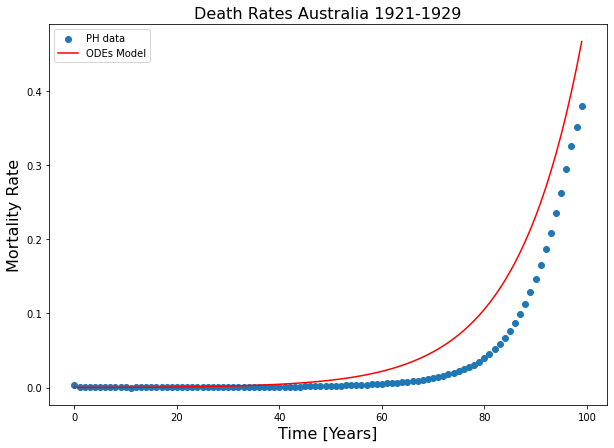

In [174]:
plt.figure(figsize=(10,7))
plt.title(r"Death Rates Australia 1921-1929", fontsize = 16)
plt.xlabel(r"Time [Years]", fontsize = 16)
plt.ylabel(r"Mortality Rate", fontsize = 16)
plt.scatter(datos_generales["Ages"], datos_generales["2010-2019"], label = "PH data")
plt.plot(gompertz_law_differential_equation[0:100], label = "ODEs Model", color = "red")

#plt.plot(gompertz_law_stochastic_simulation[0:100], label = "Stochastic Simulation", color = "green")
plt.legend()

# Canada Data Analysis

In [2]:
# Lectura datos fenomenologicos
with open('Mx_1x10/CAN.Mx_1x10.txt', 'r') as file:
    # Lee la primera línea (encabezado) y divídela en una lista
    header = file.readline().strip().split()

    # Inicializa listas vacías para almacenar los datos
    years = []
    ages = []
    females = []
    males = []
    totals = []

    row_count = 0
    for line in file:
        row_count += 1
        if row_count == 1:
            continue
        if row_count == 2:
            continue

        data = line.strip().split()
        years.append((data[0]))

        if data[1] == "110+":
            ages.append(110)
        else:
            ages.append(float(data[1]))
        if data[2] == ".":
            females.append(0)
        else:
            females.append(float(data[2]))
        if data[3] == ".":
            males.append(0)
        else:
            males.append(float(data[3]))
        if data[4] == ".":
            totals.append(0)
        else:
            totals.append(float(data[4]))
years = np.array(years)
ages = np.array(ages)
females = np.array(females)
males = np.array(males)
totals = np.array(totals)

In [3]:
years_of_interes = ["1921-1929", "1970-1979", "2010-2019"]

datos_generales = {}
datos_generales["Ages"] = ages[0:100]
for specific_year in years_of_interes:
    posicion_inicial = np.where(years == specific_year)[0][0]
    
    death_rate = totals[posicion_inicial:posicion_inicial+100]
    datos_generales[specific_year] = death_rate

In [37]:
tiempo_vida_inicial = 20
tiempo_vida_maximo = 150            #Para que los resultados obtenidos se encuentren ligados a realidad biologica
pasos_integracion = 150             #Definicion de los pasos de integracion de algoritmo
alpha_damage_propagation = 0.05    #Tasa de propagacion de daño
coupling_factor = 0.089             #Factor de acoplamiento entre frailty index y gompertz
mortality_rate = 4.3*(10**(-5))     #Tasa de mortalidad
disease_rate = 0.02
N_total_nodes = [1000]

In [49]:
initial_condition = 2
def f(x, alpha_damage_propagation, disease_rate, t=None):
    return alpha_damage_propagation*x + disease_rate

def Runke_Kutta_Method(temporal_evolution:list, disease_rate):
    x = initial_condition                                         #Initial condition     
    frailty_index = np.empty((len(temporal_evolution)))
    for index, t in enumerate(temporal_evolution):
        frailty_index[index] = x
        k1 = h*f(x, alpha_damage_propagation, disease_rate, t=t)
        k2 = h*f(x+0.5*k1, alpha_damage_propagation, disease_rate, t=t +0.5*h)
        x += k2

    gompertz_law = mortality_rate*(frailty_index**(coupling_factor/alpha_damage_propagation))
    return frailty_index, gompertz_law, temporal_evolution

In [39]:
h = (tiempo_vida_maximo-tiempo_vida_inicial)/pasos_integracion                                         #Pasos de integracion
temporal_evolution = np.arange(tiempo_vida_inicial,tiempo_vida_maximo,h) 
frailty_index_differential_equation,gompertz_law_differential_equation,temporal_evolution_differential_equation = Runke_Kutta_Method(temporal_evolution, disease_rate)


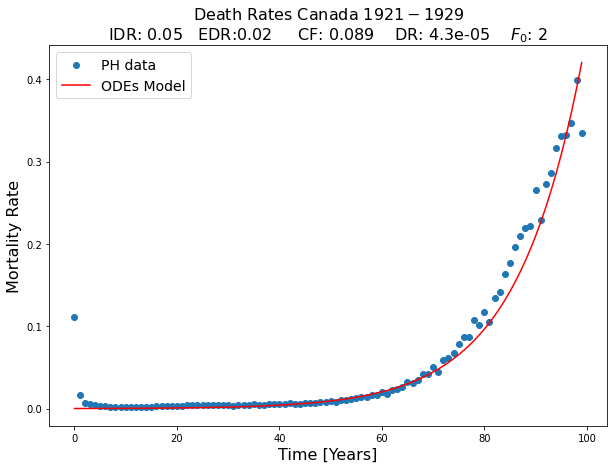

In [45]:
plt.figure(figsize=(10,7))
plt.title(r"Death Rates Canada $1921-1929$" + "\n" + rf"IDR: {alpha_damage_propagation}   EDR:{disease_rate}     CF: {coupling_factor}    DR: {mortality_rate}    $F_0$: {initial_condition}" , fontsize = 16)
plt.xlabel(r"Time [Years]", fontsize = 16)
plt.ylabel(r"Mortality Rate", fontsize = 16)
plt.scatter(datos_generales["Ages"], datos_generales["1921-1929"], label = "PH data")
plt.plot(gompertz_law_differential_equation[0:100], label = "ODEs Model", color = "red")

#plt.plot(gompertz_law_stochastic_simulation[0:100], label = "Stochastic Simulation", color = "green")
plt.legend(fontsize = 14)
plt.savefig("DR_CAN_1921_1929.jpg", dpi = 500)

# USA Data Analysis

In [48]:
# Lectura datos fenomenologicos
with open('Mx_1x10/USA.Mx_1x10.txt', 'r') as file:
    # Lee la primera línea (encabezado) y divídela en una lista
    header = file.readline().strip().split()

    # Inicializa listas vacías para almacenar los datos
    years = []
    ages = []
    females = []
    males = []
    totals = []

    row_count = 0
    for line in file:
        row_count += 1
        if row_count == 1:
            continue
        if row_count == 2:
            continue

        data = line.strip().split()
        years.append((data[0]))

        if data[1] == "110+":
            ages.append(110)
        else:
            ages.append(float(data[1]))
        if data[2] == ".":
            females.append(0)
        else:
            females.append(float(data[2]))
        if data[3] == ".":
            males.append(0)
        else:
            males.append(float(data[3]))
        if data[4] == ".":
            totals.append(0)
        else:
            totals.append(float(data[4]))
years = np.array(years)
ages = np.array(ages)
females = np.array(females)
males = np.array(males)
totals = np.array(totals)

years_of_interes = ["1933-1939", "1970-1979", "2010-2019"]

datos_generales = {}
datos_generales["Ages"] = ages[0:100]
for specific_year in years_of_interes:
    posicion_inicial = np.where(years == specific_year)[0][0]
    
    death_rate = totals[posicion_inicial:posicion_inicial+100]
    datos_generales[specific_year] = death_rate

In [305]:
tiempo_vida_inicial = 20
tiempo_vida_maximo = 150            #Para que los resultados obtenidos se encuentren ligados a realidad biologica
pasos_integracion = 150             #Definicion de los pasos de integracion de algoritmo
alpha_damage_propagation = 0.05    #Tasa de propagacion de daño
coupling_factor = 0.089            #Factor de acoplamiento entre frailty index y gompertz
mortality_rate = 4.3*(10**(-5))     #Tasa de mortalidad
disease_rate = 0.02
N_total_nodes = [1000]

In [306]:
initial_condition = 2.3
def f(x, alpha_damage_propagation, disease_rate, t=None):
    return alpha_damage_propagation*x + disease_rate

def Runke_Kutta_Method(temporal_evolution:list, disease_rate):
    x = initial_condition                                         #Initial condition     
    frailty_index = np.empty((len(temporal_evolution)))
    for index, t in enumerate(temporal_evolution):
        frailty_index[index] = x
        k1 = h*f(x, alpha_damage_propagation, disease_rate, t=t)
        k2 = h*f(x+0.5*k1, alpha_damage_propagation, disease_rate, t=t +0.5*h)
        x += k2

    gompertz_law = mortality_rate*(frailty_index**(coupling_factor/alpha_damage_propagation))
    return frailty_index, gompertz_law, temporal_evolution

In [307]:
h = (tiempo_vida_maximo-tiempo_vida_inicial)/pasos_integracion                                         #Pasos de integracion
temporal_evolution = np.arange(tiempo_vida_inicial,tiempo_vida_maximo,h) 
frailty_index_differential_equation,gompertz_law_differential_equation,temporal_evolution_differential_equation = Runke_Kutta_Method(temporal_evolution, disease_rate)


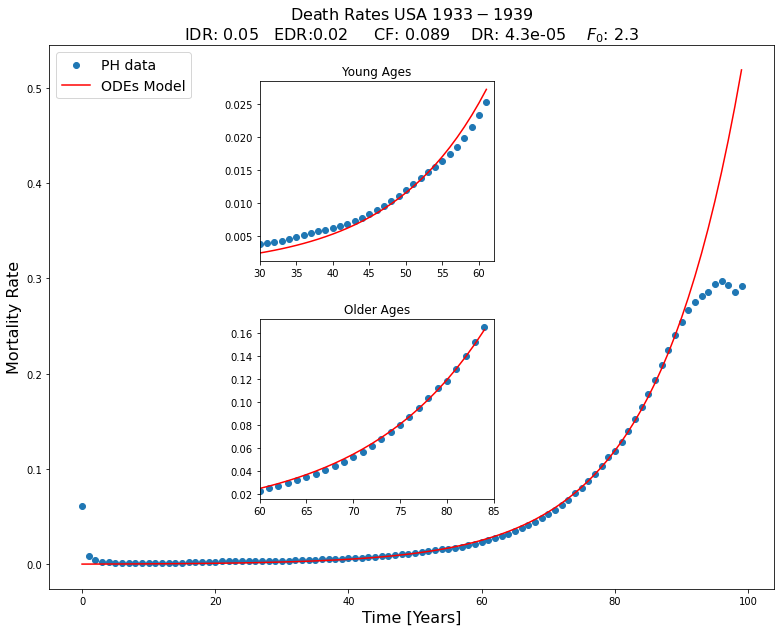

In [310]:
plt.figure(figsize=(13,10))
plt.title(r"Death Rates USA $1933-1939$" + "\n" + rf"IDR: {alpha_damage_propagation}   EDR:{disease_rate}     CF: {coupling_factor}    DR: {mortality_rate}    $F_0$: {initial_condition}" , fontsize = 16)
plt.xlabel(r"Time [Years]", fontsize = 16)
plt.ylabel(r"Mortality Rate", fontsize = 16)

zoom_ventana1 = [30, 62]  # Límites en el eje x para la primera ventana
zoom_ventana2 = [60, 85]  # Límites en el eje x para la segunda ventana


plt.scatter(datos_generales["Ages"], datos_generales["1933-1939"], label = "PH data")
plt.plot(gompertz_law_differential_equation[0:100], label = "ODEs Model", color = "red")
plt.legend(fontsize = 14)

ax1 = plt.axes([0.35, 0.58, 0.25, 0.25])  # Coordenadas y tamaño de la ventana 1
ax1.scatter(datos_generales["Ages"][zoom_ventana1[0]:zoom_ventana1[1]], datos_generales["1933-1939"][zoom_ventana1[0]:zoom_ventana1[1]])
ax1.plot(datos_generales["Ages"][zoom_ventana1[0]:zoom_ventana1[1]],gompertz_law_differential_equation[0:100][zoom_ventana1[0]:zoom_ventana1[1]], color = "red")
ax1.set_xlim(zoom_ventana1)


ax2 = plt.axes([0.35, 0.25, 0.25, 0.25])  # Coordenadas y tamaño de la ventana 2
ax2.scatter(datos_generales["Ages"][zoom_ventana2[0]:zoom_ventana2[1]], datos_generales["1933-1939"][zoom_ventana2[0]:zoom_ventana2[1]])
ax2.plot(datos_generales["Ages"][zoom_ventana2[0]:zoom_ventana2[1]],gompertz_law_differential_equation[0:100][zoom_ventana2[0]:zoom_ventana2[1]], color = "red")
ax2.set_xlim(zoom_ventana2)

ax1.set_title('Young Ages')
ax2.set_title('Older Ages')

#plt.savefig("DR_USA_1933_1939.jpg", dpi = 500)

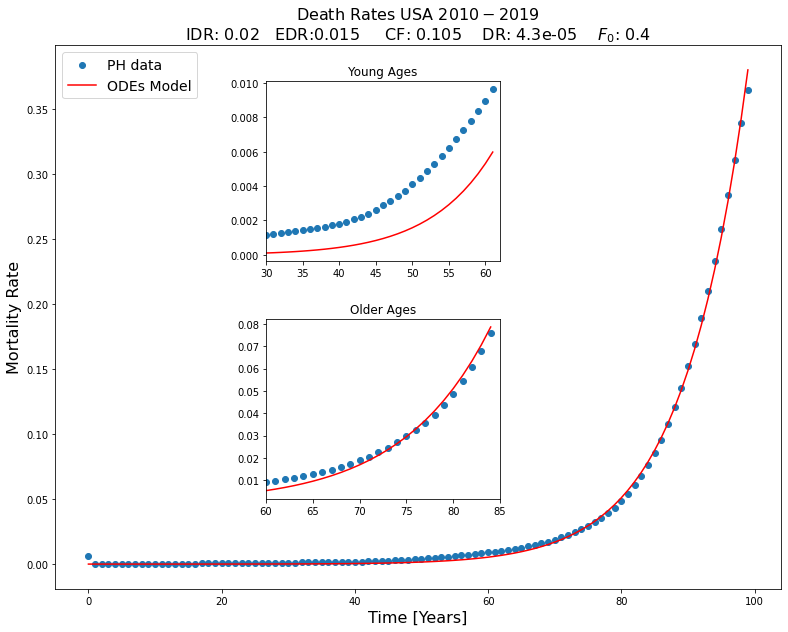

In [304]:
plt.figure(figsize=(13,10))
plt.title(r"Death Rates USA $2010-2019$" + "\n" + rf"IDR: {alpha_damage_propagation}   EDR:{disease_rate}     CF: {coupling_factor}    DR: {mortality_rate}    $F_0$: {initial_condition}" , fontsize = 16)
plt.xlabel(r"Time [Years]", fontsize = 16)
plt.ylabel(r"Mortality Rate", fontsize = 16)

zoom_ventana1 = [30, 62]  # Límites en el eje x para la primera ventana
zoom_ventana2 = [60, 85]  # Límites en el eje x para la segunda ventana


plt.scatter(datos_generales["Ages"], datos_generales["2010-2019"], label = "PH data")
plt.plot(gompertz_law_differential_equation[0:100], label = "ODEs Model", color = "red")
plt.legend(fontsize = 14)

ax1 = plt.axes([0.35, 0.58, 0.25, 0.25])  # Coordenadas y tamaño de la ventana 1
ax1.scatter(datos_generales["Ages"][zoom_ventana1[0]:zoom_ventana1[1]], datos_generales["2010-2019"][zoom_ventana1[0]:zoom_ventana1[1]])
ax1.plot(datos_generales["Ages"][zoom_ventana1[0]:zoom_ventana1[1]],gompertz_law_differential_equation[0:100][zoom_ventana1[0]:zoom_ventana1[1]], color = "red")
ax1.set_xlim(zoom_ventana1)


ax2 = plt.axes([0.35, 0.25, 0.25, 0.25])  # Coordenadas y tamaño de la ventana 2
ax2.scatter(datos_generales["Ages"][zoom_ventana2[0]:zoom_ventana2[1]], datos_generales["2010-2019"][zoom_ventana2[0]:zoom_ventana2[1]])
ax2.plot(datos_generales["Ages"][zoom_ventana2[0]:zoom_ventana2[1]],gompertz_law_differential_equation[0:100][zoom_ventana2[0]:zoom_ventana2[1]], color = "red")
ax2.set_xlim(zoom_ventana2)

ax1.set_title('Young Ages')
ax2.set_title('Older Ages')

#plt.savefig("DR_USA_2010_2019.jpg", dpi = 500)